<a href="https://colab.research.google.com/github/sparsh-ai/reco-book/blob/stage/nbs/T186367_Node2vec_library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node2vec from scratch referencing node2vec library

## Codebase

In [ ]:
import os
import random
from collections import defaultdict

import gensim
import networkx as nx
import numpy as np
import pkg_resources
from joblib import Parallel, delayed
from tqdm.auto import tqdm

from abc import ABC, abstractmethod
from functools import reduce
from itertools import combinations_with_replacement

from gensim.models import KeyedVectors

In [ ]:
def parallel_generate_walks(d_graph: dict, global_walk_length: int, num_walks: int, cpu_num: int,
                            sampling_strategy: dict = None, num_walks_key: str = None, walk_length_key: str = None,
                            neighbors_key: str = None, probabilities_key: str = None, first_travel_key: str = None,
                            quiet: bool = False) -> list:
    """
    Generates the random walks which will be used as the skip-gram input.
    :return: List of walks. Each walk is a list of nodes.
    """

    walks = list()

    if not quiet:
        pbar = tqdm(total=num_walks, desc='Generating walks (CPU: {})'.format(cpu_num))

    for n_walk in range(num_walks):

        # Update progress bar
        if not quiet:
            pbar.update(1)

        # Shuffle the nodes
        shuffled_nodes = list(d_graph.keys())
        random.shuffle(shuffled_nodes)

        # Start a random walk from every node
        for source in shuffled_nodes:

            # Skip nodes with specific num_walks
            if source in sampling_strategy and \
                    num_walks_key in sampling_strategy[source] and \
                    sampling_strategy[source][num_walks_key] <= n_walk:
                continue

            # Start walk
            walk = [source]

            # Calculate walk length
            if source in sampling_strategy:
                walk_length = sampling_strategy[source].get(walk_length_key, global_walk_length)
            else:
                walk_length = global_walk_length

            # Perform walk
            while len(walk) < walk_length:

                walk_options = d_graph[walk[-1]].get(neighbors_key, None)

                # Skip dead end nodes
                if not walk_options:
                    break

                if len(walk) == 1:  # For the first step
                    probabilities = d_graph[walk[-1]][first_travel_key]
                    walk_to = np.random.choice(walk_options, size=1, p=probabilities)[0]
                else:
                    probabilities = d_graph[walk[-1]][probabilities_key][walk[-2]]
                    walk_to = np.random.choice(walk_options, size=1, p=probabilities)[0]

                walk.append(walk_to)

            walk = list(map(str, walk))  # Convert all to strings

            walks.append(walk)

    if not quiet:
        pbar.close()

    return walks

In [ ]:
class Node2Vec:
    FIRST_TRAVEL_KEY = 'first_travel_key'
    PROBABILITIES_KEY = 'probabilities'
    NEIGHBORS_KEY = 'neighbors'
    WEIGHT_KEY = 'weight'
    NUM_WALKS_KEY = 'num_walks'
    WALK_LENGTH_KEY = 'walk_length'
    P_KEY = 'p'
    Q_KEY = 'q'

    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, weight_key: str = 'weight', workers: int = 1, sampling_strategy: dict = None,
                 quiet: bool = False, temp_folder: str = None, seed: int = None):
        """
        Initiates the Node2Vec object, precomputes walking probabilities and generates the walks.
        :param graph: Input graph
        :param dimensions: Embedding dimensions (default: 128)
        :param walk_length: Number of nodes in each walk (default: 80)
        :param num_walks: Number of walks per node (default: 10)
        :param p: Return hyper parameter (default: 1)
        :param q: Inout parameter (default: 1)
        :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
        :param workers: Number of workers for parallel execution (default: 1)
        :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'.
        :param seed: Seed for the random number generator.
        Use these keys exactly. If not set, will use the global ones which were passed on the object initialization
        :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
        """

        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.workers = workers
        self.quiet = quiet
        self.d_graph = defaultdict(dict)

        if sampling_strategy is None:
            self.sampling_strategy = {}
        else:
            self.sampling_strategy = sampling_strategy

        self.temp_folder, self.require = None, None
        if temp_folder:
            if not os.path.isdir(temp_folder):
                raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

            self.temp_folder = temp_folder
            self.require = "sharedmem"

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node.
        """

        d_graph = self.d_graph

        nodes_generator = self.graph.nodes() if self.quiet \
            else tqdm(self.graph.nodes(), desc='Computing transition probabilities')

        for source in nodes_generator:

            # Init probabilities dict for first travel
            if self.PROBABILITIES_KEY not in d_graph[source]:
                d_graph[source][self.PROBABILITIES_KEY] = dict()

            for current_node in self.graph.neighbors(source):

                # Init probabilities dict
                if self.PROBABILITIES_KEY not in d_graph[current_node]:
                    d_graph[current_node][self.PROBABILITIES_KEY] = dict()

                unnormalized_weights = list()
                d_neighbors = list()

                # Calculate unnormalized weights
                for destination in self.graph.neighbors(current_node):

                    p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                                 self.p) if current_node in self.sampling_strategy else self.p
                    q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                                 self.q) if current_node in self.sampling_strategy else self.q

                    if destination == source:  # Backwards probability
                        ss_weight = self.graph[current_node][destination].get(self.weight_key, 1) * 1 / p
                    elif destination in self.graph[source]:  # If the neighbor is connected to the source
                        ss_weight = self.graph[current_node][destination].get(self.weight_key, 1)
                    else:
                        ss_weight = self.graph[current_node][destination].get(self.weight_key, 1) * 1 / q

                    # Assign the unnormalized sampling strategy weight, normalize during random walk
                    unnormalized_weights.append(ss_weight)
                    d_neighbors.append(destination)

                # Normalize
                unnormalized_weights = np.array(unnormalized_weights)
                d_graph[current_node][self.PROBABILITIES_KEY][
                    source] = unnormalized_weights / unnormalized_weights.sum()

            # Calculate first_travel weights for source
            first_travel_weights = []

            for destination in self.graph.neighbors(source):
                first_travel_weights.append(self.graph[source][destination].get(self.weight_key, 1))

            first_travel_weights = np.array(first_travel_weights)
            d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()

            # Save neighbors
            d_graph[source][self.NEIGHBORS_KEY] = list(self.graph.neighbors(source))

    def _generate_walks(self) -> list:
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """

        flatten = lambda l: [item for sublist in l for item in sublist]

        # Split num_walks for each worker
        num_walks_lists = np.array_split(range(self.num_walks), self.workers)

        walk_results = Parallel(n_jobs=self.workers, temp_folder=self.temp_folder, require=self.require)(
            delayed(parallel_generate_walks)(self.d_graph,
                                             self.walk_length,
                                             len(num_walks),
                                             idx,
                                             self.sampling_strategy,
                                             self.NUM_WALKS_KEY,
                                             self.WALK_LENGTH_KEY,
                                             self.NEIGHBORS_KEY,
                                             self.PROBABILITIES_KEY,
                                             self.FIRST_TRAVEL_KEY,
                                             self.quiet) for
            idx, num_walks
            in enumerate(num_walks_lists, 1))

        walks = flatten(walk_results)

        return walks

    def fit(self, **skip_gram_params) -> gensim.models.Word2Vec:
        """
        Creates the embeddings using gensim's Word2Vec.
        :param skip_gram_params: Parameters for gensim.models.Word2Vec - do not supply 'size' / 'vector_size' it is
            taken from the Node2Vec 'dimensions' parameter
        :type skip_gram_params: dict
        :return: A gensim word2vec model
        """

        if 'workers' not in skip_gram_params:
            skip_gram_params['workers'] = self.workers

        # Figure out gensim version, naming of output dimensions changed from size to vector_size in v4.0.0
        gensim_version = pkg_resources.get_distribution("gensim").version
        size = 'size' if gensim_version < '4.0.0' else 'vector_size'
        if size not in skip_gram_params:
            skip_gram_params[size] = self.dimensions

        if 'sg' not in skip_gram_params:
            skip_gram_params['sg'] = 1

        return gensim.models.Word2Vec(self.walks, **skip_gram_params)

In [ ]:
class EdgeEmbedder(ABC):
    INDEX_MAPPING_KEY = 'index2word' if pkg_resources.get_distribution("gensim").version < '4.0.0' else 'index_to_key'

    def __init__(self, keyed_vectors: KeyedVectors, quiet: bool = False):
        """
        :param keyed_vectors: KeyedVectors containing nodes and embeddings to calculate edges for
        """

        self.kv = keyed_vectors
        self.quiet = quiet

    @abstractmethod
    def _embed(self, edge: tuple) -> np.ndarray:
        """
        Abstract method for implementing the embedding method
        :param edge: tuple of two nodes
        :return: Edge embedding
        """
        pass

    def __getitem__(self, edge) -> np.ndarray:
        if not isinstance(edge, tuple) or not len(edge) == 2:
            raise ValueError('edge must be a tuple of two nodes')

        if edge[0] not in getattr(self.kv, self.INDEX_MAPPING_KEY):
            raise KeyError('node {} does not exist in given KeyedVectors'.format(edge[0]))

        if edge[1] not in getattr(self.kv, self.INDEX_MAPPING_KEY):
            raise KeyError('node {} does not exist in given KeyedVectors'.format(edge[1]))

        return self._embed(edge)

    def as_keyed_vectors(self) -> KeyedVectors:
        """
        Generated a KeyedVectors instance with all the possible edge embeddings
        :return: Edge embeddings
        """

        edge_generator = combinations_with_replacement(getattr(self.kv, self.INDEX_MAPPING_KEY), r=2)

        if not self.quiet:
            vocab_size = len(getattr(self.kv, self.INDEX_MAPPING_KEY))
            total_size = reduce(lambda x, y: x * y, range(1, vocab_size + 2)) / \
                         (2 * reduce(lambda x, y: x * y, range(1, vocab_size)))

            edge_generator = tqdm(edge_generator, desc='Generating edge features', total=total_size)

        # Generate features
        tokens = []
        features = []
        for edge in edge_generator:
            token = str(tuple(sorted(edge)))
            embedding = self._embed(edge)

            tokens.append(token)
            features.append(embedding)

        # Build KV instance
        edge_kv = KeyedVectors(vector_size=self.kv.vector_size)
        if pkg_resources.get_distribution("gensim").version < '4.0.0':
            edge_kv.add(
                entities=tokens,
                weights=features)
        else:
            edge_kv.add_vectors(
                keys=tokens,
                weights=features)

        return edge_kv


class AverageEmbedder(EdgeEmbedder):
    """
    Average node features
    """

    def _embed(self, edge: tuple):
        return (self.kv[edge[0]] + self.kv[edge[1]]) / 2


class HadamardEmbedder(EdgeEmbedder):
    """
    Hadamard product node features
    """

    def _embed(self, edge: tuple):
        return self.kv[edge[0]] * self.kv[edge[1]]


class WeightedL1Embedder(EdgeEmbedder):
    """
    Weighted L1 node features
    """

    def _embed(self, edge: tuple):
        return np.abs(self.kv[edge[0]] - self.kv[edge[1]])


class WeightedL2Embedder(EdgeEmbedder):
    """
    Weighted L2 node features
    """

    def _embed(self, edge: tuple):
        return (self.kv[edge[0]] - self.kv[edge[1]]) ** 2

## Scenario

In [ ]:
# Create a graph
graph = nx.fast_gnp_random_graph(n=100, p=0.5)

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format('embeddings.p')

# Save model for later use
model.save('model.p')

In [ ]:
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
edges_embs[('1', '2')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
edges_kv.save_word2vec_format('edge_embeddings.p')

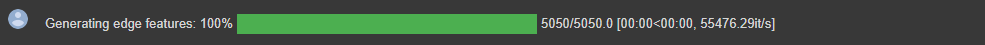